In [ ]:
#Tensorflow version 1.x

In [1]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams 
from sklearn import metrics
from sklearn.model_selection import train_test_split
tf.compat.v1.disable_eager_execution()


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
import zipfile
with zipfile.ZipFile('/content/UCI HAR Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('')

--2021-04-28 05:21:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  73.9MB/s    in 0.8s    

2021-04-28 05:21:34 (73.9 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [4]:
def one_hot(y):
    """convert label from dense to one hot
      argument:
        label: ndarray dense label ,shape: [sample_num,1]
      return:
        one_hot_label: ndarray  one hot, shape: [sample_num,n_class]
    """
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]

    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def batch_norm(input_tensor, config, i):
    # Implementing batch normalisation: this is used out of the residual layers
    # to normalise those output neurons by mean and standard deviation.

    if config.n_layers_in_highway == 0:
        # There is no residual layers, no need for batch_norm:
        return input_tensor

    with tf.compat.v1.variable_scope("batch_norm") as scope:
        if i != 0:
            # Do not create extra variables for each time step
            scope.reuse_variables()

        # Mean and variance normalisation simply crunched over all axes
        axes = list(range(len(input_tensor.get_shape())))

        mean, variance = tf.nn.moments(input_tensor, axes=axes, shift=None, name=None)
        stdev = tf.sqrt(variance+0.001)

        # Rescaling
        bn = input_tensor - mean
        bn /= stdev
        # Learnable extra rescaling

        # tf.get_variable("relu_fc_weights", initializer=tf.random_normal(mean=0.0, stddev=0.0)
        bn *= tf.compat.v1.get_variable("a_noreg", initializer=tf.compat.v1.random_normal([1], mean=0.5, stddev=0.0))
        bn += tf.compat.v1.get_variable("b_noreg", initializer=tf.compat.v1.random_normal([1], mean=0.0, stddev=0.0))
        # bn *= tf.Variable(0.5, name=(scope.name + "/a_noreg"))
        # bn += tf.Variable(0.0, name=(scope.name + "/b_noreg"))

    return bn

def relu_fc(input_2D_tensor_list, features_len, new_features_len, config):
    """make a relu fully-connected layer, mainly change the shape of tensor
       both input and output is a list of tensor
        argument:
            input_2D_tensor_list: list shape is [batch_size,feature_num]
            features_len: int the initial features length of input_2D_tensor
            new_feature_len: int the final features length of output_2D_tensor
            config: Config used for weights initializers
        return:
            output_2D_tensor_list lit shape is [batch_size,new_feature_len]
    """

    W = tf.compat.v1.get_variable(
        "relu_fc_weights",
        initializer=tf.compat.v1.random_normal(
            [features_len, new_features_len],
            mean=0.0,
            stddev=float(config.weights_stddev)
        )
    )
    b = tf.compat.v1.get_variable(
        "relu_fc_biases_noreg",
        initializer=tf.compat.v1.random_normal(
            [new_features_len],
            mean=float(config.bias_mean),
            stddev=float(config.weights_stddev)
        )
    )

    # intra-timestep multiplication:
    output_2D_tensor_list = [
        tf.nn.relu(tf.matmul(input_2D_tensor, W) + b)
            for input_2D_tensor in input_2D_tensor_list
    ]

    return output_2D_tensor_list


def single_LSTM_cell(input_hidden_tensor, n_outputs):
    """ define the basic LSTM layer
        argument:
            input_hidden_tensor: list a list of tensor,
                                 shape: time_steps*[batch_size,n_inputs]
            n_outputs: int num of LSTM layer output
        return:
            outputs: list a time_steps list of tensor,
                     shape: time_steps*[batch_size,n_outputs]
    """
    with tf.compat.v1.variable_scope("lstm_cell"):
        lstm_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_outputs, state_is_tuple=True, forget_bias=0.999)
        outputs, _ = tf.compat.v1.nn.static_rnn(lstm_cell, input_hidden_tensor, dtype=tf.float32)
    return outputs


def bi_LSTM_cell(input_hidden_tensor, n_inputs, n_outputs, config):
    """build bi-LSTM, concatenating the two directions in an inner manner.
        argument:
            input_hidden_tensor: list a time_steps series of tensor, shape: [sample_num, n_inputs]
            n_inputs: int units of input tensor
            n_outputs: int units of output tensor, each bi-LSTM will have half those internal units
            config: Config used for the relu_fc
        return:
            layer_hidden_outputs: list a time_steps series of tensor, shape: [sample_num, n_outputs]
    """
    n_outputs = int(n_outputs/2)

    print ("bidir:")

    with tf.compat.v1.variable_scope('pass_forward') as scope2:
        hidden_forward = relu_fc(input_hidden_tensor, n_inputs, n_outputs, config)
        forward = single_LSTM_cell(hidden_forward, n_outputs)

    print (len(hidden_forward), str(hidden_forward[0].get_shape()))

    # Backward pass is as simple as surrounding the cell with a double inversion:
    with tf.compat.v1.variable_scope('pass_backward') as scope2:
        hidden_backward = relu_fc(input_hidden_tensor, n_inputs, n_outputs, config)
        backward = list(reversed(single_LSTM_cell(list(reversed(hidden_backward)), n_outputs)))

    with tf.compat.v1.variable_scope('bidir_concat') as scope:
        # Simply concatenating cells' outputs at each timesteps on the innermost
        # dimension, like if the two cells acted as one cell
        # with twice the n_hidden size:
        layer_hidden_outputs = [
            tf.concat( [f, b],len(f.get_shape()) - 1)
                for f, b in zip(forward, backward)]

    return layer_hidden_outputs


def residual_bidirectional_LSTM_layers(input_hidden_tensor, n_input, n_output, layer_level, config, keep_prob_for_dropout):
    """This architecture is only enabled if "config.n_layers_in_highway" has a
    value only greater than int(0). The arguments are same than for bi_LSTM_cell.
    arguments:
        input_hidden_tensor: list a time_steps series of tensor, shape: [sample_num, n_inputs]
        n_inputs: int units of input tensor
        n_outputs: int units of output tensor, each bi-LSTM will have half those internal units
        config: Config used for determining if there are residual connections and if yes, their number and with some batch_norm.
    return:
        layer_hidden_outputs: list a time_steps series of tensor, shape: [sample_num, n_outputs]
    """
    with tf.compat.v1.variable_scope('layer_{}'.format(layer_level)) as scope:

        if config.use_bidirectionnal_cells:
            get_lstm = lambda input_tensor: bi_LSTM_cell(input_tensor, n_input, n_output, config)
        else:
            get_lstm = lambda input_tensor: single_LSTM_cell(relu_fc(input_tensor, n_input, n_output, config), n_output)
        def add_highway_redisual(layer, residual_minilayer):
            return [a + b for a, b in zip(layer, residual_minilayer)]

        hidden_LSTM_layer = get_lstm(input_hidden_tensor)
        # Adding K new (residual bidir) connections to this first layer:
        for i in range(config.n_layers_in_highway - 1):
            with tf.compat.v1.variable_scope('LSTM_residual_{}'.format(i)) as scope2:
                hidden_LSTM_layer = add_highway_redisual(
                    hidden_LSTM_layer,
                    get_lstm(input_hidden_tensor)
                )

        if config.also_add_dropout_between_stacked_cells:
            hidden_LSTM_layer = [tf.nn.dropout(out, keep_prob_for_dropout) for out in hidden_LSTM_layer]

        return [batch_norm(out, config, i) for i, out in enumerate(hidden_LSTM_layer)]


def LSTM_network(feature_mat, config, keep_prob_for_dropout):
    """model a LSTM Network,
      it stacks 2 LSTM layers, each layer has n_hidden=32 cells
       and 1 output layer, it is a full connet layer
      argument:
        feature_mat: ndarray fature matrix, shape=[batch_size,time_steps,n_inputs]
        config: class containing config of network
      return:
              : ndarray  output shape [batch_size, n_classes]
    """

    with tf.compat.v1.variable_scope('LSTM_network') as scope:  # TensorFlow graph naming

        feature_mat = tf.nn.dropout(feature_mat, keep_prob_for_dropout)
        
        # Exchange dim 1 and dim 0
        feature_mat = tf.transpose(feature_mat, [1, 0, 2])
        print (feature_mat.get_shape())
        # New feature_mat's shape: [time_steps, batch_size, n_inputs]

        # Temporarily crush the feature_mat's dimensions
        feature_mat = tf.reshape(feature_mat, [-1, config.n_inputs])
        print (feature_mat.get_shape())
        # New feature_mat's shape: [time_steps*batch_size, n_inputs]

        # Split the series because the rnn cell needs time_steps features, each of shape:
        hidden = tf.split(feature_mat, config.n_steps, 0)
        print (len(hidden), str(hidden[0].get_shape()))
        # New shape: a list of lenght "time_step" containing tensors of shape [batch_size, n_hidden]

        # Stacking LSTM cells, at least one is stacked:
        print ("\nCreating hidden #1:")
        hidden = residual_bidirectional_LSTM_layers(hidden, config.n_inputs, config.n_hidden, 1, config, keep_prob_for_dropout)
        print (len(hidden), str(hidden[0].get_shape()))

        for stacked_hidden_index in range(config.n_stacked_layers - 1):
            # If the config permits it, we stack more lstm cells:
            print ("\nCreating hidden #{}:".format(stacked_hidden_index+2))
            hidden = residual_bidirectional_LSTM_layers(hidden, config.n_hidden, config.n_hidden, stacked_hidden_index+2, config, keep_prob_for_dropout)
            print (len(hidden), str(hidden[0].get_shape()))

        print ("")

        # Final fully-connected activation logits
        # Get the last output tensor of the inner loop output series, of shape [batch_size, n_classes]
        last_hidden = tf.nn.dropout(hidden[-1], keep_prob_for_dropout)
        last_logits = relu_fc(
            [last_hidden],
            config.n_hidden, config.n_classes, config
        )[0]
        return last_logits


def run_with_config(Config, X_train, y_train, X_test, y_test):
    #tf.reset_default_graph()  # To enable to run multiple things in a loop
    tf.compat.v1.reset_default_graph()
    #-----------------------------------
    # Define parameters for model
    #-----------------------------------
    config = Config(X_train, X_test)
    print("Some useful info to get an insight on dataset's shape and normalisation:")
    print("features shape, labels shape, each features mean, each features standard deviation")
    print(X_test.shape, y_test.shape,
          np.mean(X_test), np.std(X_test))
    print("the dataset is therefore properly normalised, as expected.")

    #------------------------------------------------------
    # Let's get serious and build the neural network
    #------------------------------------------------------
    #with tf.device("/cpu:0"):  # Remove this line to use GPU. If you have a too small GPU, it crashes.
    X = tf.compat.v1.placeholder(tf.float32, [
                           None, config.n_steps, config.n_inputs], name="X")
    Y = tf.compat.v1.placeholder(tf.float32, [
                           None, config.n_classes], name="Y")

        # is_train for dropout control:
    is_train = tf.compat.v1.placeholder(tf.bool, name="is_train")
    keep_prob_for_dropout = tf.cond(is_train,
            lambda: tf.constant(
                config.keep_prob_for_dropout,
                name="keep_prob_for_dropout"
            ),
            lambda: tf.constant(
                1.0,
                name="keep_prob_for_dropout"
            )
        )

    pred_y = LSTM_network(X, config, keep_prob_for_dropout)

        # Loss, optimizer, evaluation

        # Softmax loss with L2 and L1 layer-wise regularisation
    print ("Unregularised variables:")
    for unreg in [tf_var.name for tf_var in tf.compat.v1.trainable_variables() if ("noreg" in tf_var.name or "Bias" in tf_var.name)]:
          print (unreg)
    l2 = config.lambda_loss_amount * sum(
            tf.nn.l2_loss(tf_var)
                for tf_var in tf.compat.v1.trainable_variables()
                if not ("noreg" in tf_var.name or "Bias" in tf_var.name)
        )
        # first_weights = [w for w in tf.all_variables() if w.name == 'LSTM_network/layer_1/pass_forward/relu_fc_weights:0'][0]
        # l1 = config.lambda_loss_amount * tf.reduce_mean(tf.abs(first_weights))
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits=pred_y, labels= Y)) + l2  # + l1

        # Gradient clipping Adam optimizer with gradient noise
    optimize = tf.contrib.layers.optimize_loss(
            loss,
            global_step=tf.Variable(0),
            learning_rate=config.learning_rate,
            optimizer=tf.train.AdamOptimizer(learning_rate=config.learning_rate),
            clip_gradients=config.clip_gradients,
            gradient_noise_scale=config.gradient_noise_scale
        )

    correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(Y, 1),name="y_")
    accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

    #--------------------------------------------
    # Hooray, now train the neural network
    #--------------------------------------------
    # Note that log_device_placement can be turned of for less console spam.

    saver = tf.train.Saver()

    history = dict(train_loss=[], 
                     train_acc=[], 
                     test_losses=[], 
                     test_accuracies=[])
    
    sessconfig = tf.ConfigProto(log_device_placement=False)
    with tf.Session(config=sessconfig) as sess:
        tf.global_variables_initializer().run()

        best_accuracy = (0.0, "iter: -1")
        best_f1_score = (0.0, "iter: -1")

        # Start training for each batch and loop epochs

        worst_batches = []
        acc=[]
        acc_train=[]
        f1=[]
        f1_train=[]
        for i in range(config.training_epochs):

            
            # Loop batches for an epoch:
            shuffled_X, shuffled_y = shuffle(X_train, y_train, random_state=i*42)
            for start, end in zip(range(0, config.train_count, config.batch_size),
                                  range(config.batch_size, config.train_count + 1, config.batch_size)):

                _, train_acc, train_loss, train_pred = sess.run(
                    [optimize, accuracy, loss, pred_y],
                    feed_dict={
                        X: shuffled_X[start:end],
                        Y: shuffled_y[start:end],
                        is_train: True
                    }
                )
                
                worst_batches.append(
                    (train_loss, shuffled_X[start:end], shuffled_y[start:end])
                )
                worst_batches = list(sorted(worst_batches))[-5:]  # Keep 5 poorest
               

            # Train F1 score is not on boosting
            train_f1_score = metrics.f1_score(
                shuffled_y[start:end].argmax(1), train_pred.argmax(1), average="weighted"
            )
     
            # Retrain on top worst batches of this epoch (boosting):
            # a.k.a. "focus on the hardest exercises while training":
            for _, x_, y_ in worst_batches:

                _, train_acc, train_loss, train_pred = sess.run(
                    [optimize, accuracy, loss, pred_y],
                    feed_dict={
                        X: x_,
                        Y: y_,
                        is_train: True
                    }
                )
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            # Test completely at the end of every epoch:
            # Calculate accuracy and F1 score
            %%time
            pred_out, accuracy_out, loss_out = sess.run(
                [pred_y, accuracy, loss],
                feed_dict={
                    X: X_test,
                    Y: y_test,
                    is_train: False
                }
            )
            
            history['test_losses'].append(loss_out)
            history['test_accuracies'].append(accuracy_out)
            
            # "y_test.argmax(1)": could be optimised by being computed once...
            f1_score_out = metrics.f1_score(
                y_test.argmax(1), pred_out.argmax(1), average="weighted"
            )
            
            print (
                "iter: {}, ".format(i) + \
                "train loss: {}, ".format(train_loss) + \
                "train accuracy: {}, ".format(train_acc) + \
                "train F1-score: {}, ".format(train_f1_score) + \
                "test loss: {}, ".format(loss_out) + \
                "test accuracy: {}, ".format(accuracy_out) + \
                "test F1-score: {}".format(f1_score_out)
            )
            acc.append(accuracy_out)
            acc_train.append(train_acc)
            f1.append(f1_score_out)
            f1_train.append(train_f1_score)
            best_accuracy = max(best_accuracy, (accuracy_out, "iter: {}".format(i)))
            best_f1_score = max(best_f1_score, (f1_score_out, "iter: {}".format(i)))
            
          


        pickle.dump(pred_out, open("predictions.p", "wb"))
        pickle.dump(history, open("history.p", "wb"))
        tf.train.write_graph(sess.graph_def, '.', 'Bidir_LSTM_RNN_har.pbtxt')  
        saver.save(sess, save_path = "Bidir_LSTM_RNN_har.ckpt")
        sess.close()  
        print("")
        print("final test accuracy: {}".format(accuracy_out))
        print("best epoch's test accuracy: {}".format(best_accuracy))
        print("final F1 score: {}".format(f1_score_out))
        print("best epoch's F1 score: {}".format(best_f1_score))
        print("")
        plt.plot(acc,'r-',label='Test')
        plt.plot(acc_train,'b-',label='Train')
        plt.title("Accuracy of Deep-Res-Bidir-LSTM")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(b=True)
        plt.show()
        plt.plot(f1,'r-',label='Test')
        plt.plot(f1_train,'b-',label='Train')
        plt.title("F1 of Deep-Res-Bidir-LSTM")
        plt.xlabel('Epoch')
        plt.ylabel('F1 score')
        plt.legend()
        plt.grid(b=True)
        plt.show()
        
        total_parameters = 0
        for variable in tf.compat.v1.trainable_variables():
        # shape is an array of tf.Dimension
          shape = variable.get_shape()
          
          variable_parameters = 1
          for dim in shape:
            
            variable_parameters *= dim.value
          
          total_parameters += variable_parameters
        print(total_parameters)
    # returning both final and bests accuracies and f1 scores.
    return accuracy_out, best_accuracy, f1_score_out, best_f1_score

In [5]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=82bafd82e2d6130ae4398a95bfe77c217c2e66e3855e8cf71690e9b35283e9dd
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


In [6]:
%load_ext memory_profiler

learning_rate: 0.001
lambda_loss_amount: 0.005

Some useful info to get an insight on dataset's shape and normalisation:
features shape, labels shape, each features mean, each features standard deviation
(2947, 128, 9) (2947, 6) 0.09913992 0.39567086
the dataset is therefore properly normalised, as expected.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(128, ?, 9)
(?, 9)
128 (?, 9)

Creating hidden #1:
bidir:
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
128 (?, 14)
128 (?, 28)

Creating hidden #2:
bidir:
128 (?, 14)
128 (?, 28)

Creating hi

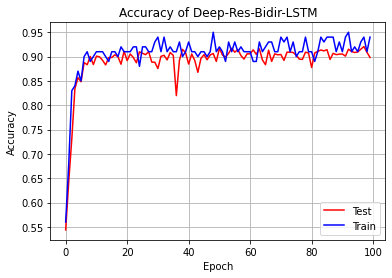

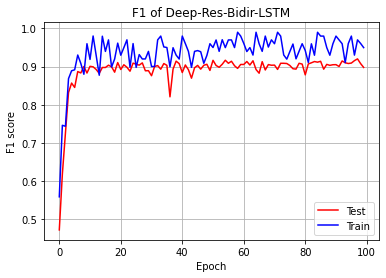

11829
0.8982016 (0.9205972, 'iter: 97') 0.8978632209778687 (0.9202653971487205, 'iter: 97')

Done.
peak memory: 3265.89 MiB, increment: 0.54 MiB


In [7]:
#--------------------------------------------
# Neural net's config.
#--------------------------------------------

class Config(object):
    """
    define a class to store parameters,
    the input should be feature mat of training and testing
    """

    def __init__(self, X_train, X_test):
        # Data shaping
        self.train_count = len(X_train)  # 7352 training series
        self.test_data_count = len(X_test)  # 2947 testing series
        self.n_steps = len(X_train[0])  # 128 time_steps per series
        self.n_classes = 6  # Final output classes

        # Training
        self.learning_rate = 0.001
        self.lambda_loss_amount = 0.005
        self.training_epochs = 100
        self.batch_size = 100
        self.clip_gradients = 15.0
        self.gradient_noise_scale = None
        # Dropout is added on inputs and after each stacked layers (but not
        # between residual layers).
        self.keep_prob_for_dropout = 0.85  # **(1/3.0)

        # Linear+relu structure
        self.bias_mean = 0.3
        # I would recommend between 0.1 and 1.0 or to change and use a xavier
        # initializer
        self.weights_stddev = 0.2

        ########
        # NOTE: I think that if any of the below parameters are changed,
        # the best is to readjust every parameters in the "Training" section
        # above to properly compare the architectures only once optimised.
        ########

        # LSTM structure
        # Features count is of 9: three 3D sensors features over time
        self.n_inputs = len(X_train[0][0])
        self.n_hidden = 28  # nb of neurons inside the neural network
        # Use bidir in every LSTM cell, or not:
        self.use_bidirectionnal_cells = True

        # High-level deep architecture
        self.also_add_dropout_between_stacked_cells = False  # True
        # NOTE: values of exactly 1 (int) for those 2 high-level parameters below totally disables them and result in only 1 starting LSTM.
        self.n_layers_in_highway = 1  # Number of residual connections to the LSTMs (highway-style), this is did for each stacked block (inside them).
        self.n_stacked_layers = 3  # Stack multiple blocks of residual
        # layers.


#--------------------------------------------
# Dataset-specific constants and functions + loading
#--------------------------------------------

# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATA_PATH = ""
DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    """
    Given attribute (train or test) of feature, read all 9 features into an
    np ndarray of shape [sample_sequence_idx, time_step, feature_num]
        argument:   X_signals_paths str attribute of feature: 'train' or 'test'
        return:     np ndarray, tensor of features
    """
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    """
    Read Y file of values to be predicted
        argument: y_path str attibute of Y: 'train' or 'test'
        return: Y ndarray / tensor of the 6 one_hot labels of each sample
    """
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_ - 1)

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


#--------------------------------------------
# Training (maybe multiple) experiment(s)
#--------------------------------------------

n_layers_in_highway = 1
n_stacked_layers = 3
trial_name = "{}x{}".format(n_layers_in_highway, n_stacked_layers)

for learning_rate in [0.001]:  # [0.01, 0.007, 0.001, 0.0007, 0.0001]:
    for lambda_loss_amount in [0.005]:
        for clip_gradients in [15.0]:
            print ("learning_rate: {}".format(learning_rate))
            print ("lambda_loss_amount: {}".format(lambda_loss_amount))
            print ("")

            class EditedConfig(Config):
                def __init__(self, X, Y):
                    super(EditedConfig, self).__init__(X, Y)

                    # Edit only some parameters:
                    self.learning_rate = learning_rate
                    self.lambda_loss_amount = lambda_loss_amount
                    self.clip_gradients = clip_gradients
                    # Architecture params:
                    self.n_layers_in_highway = n_layers_in_highway
                    self.n_stacked_layers = n_stacked_layers

            # # Useful catch upon looping (e.g.: not enough memory)
            # try:
            #     accuracy_out, best_accuracy = run_with_config(EditedConfig)
            # except:
            #     accuracy_out, best_accuracy = -1, -1
            accuracy_out, best_accuracy, f1_score_out, best_f1_score = (
                run_with_config(EditedConfig, X_train, y_train, X_test, y_test)
            )
            print (accuracy_out, best_accuracy, f1_score_out, best_f1_score)

            with open('{}_result_HAR_6.txt'.format(trial_name), 'a') as f:
                f.write(str(learning_rate) + ' \t' + str(lambda_loss_amount) + ' \t' + str(clip_gradients) + ' \t' + str(
                    accuracy_out) + ' \t' + str(best_accuracy) + ' \t' + str(f1_score_out) + ' \t' + str(best_f1_score) + '\n\n')

        print ("")
print ("Done.")


%memit

In [8]:

history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))


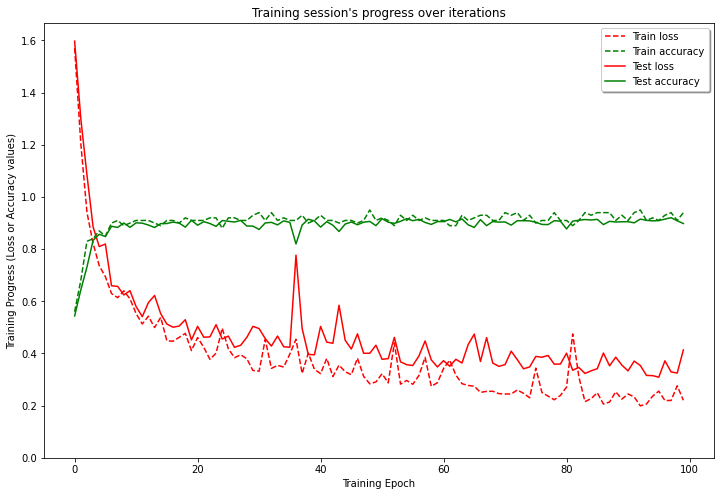

In [9]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_losses']), "r-", label="Test loss")
plt.plot(np.array(history['test_accuracies']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [10]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'Bidir_LSTM_RNN_har'

input_graph_path = MODEL_NAME+'.pbtxt'
checkpoint_path = MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

Output hidden; open in https://colab.research.google.com to view.